## Etapa 1: Instalação das dependências

In [1]:
# !pip uninstall -y tensorflow #Comando necessário, pois o TensorFlow-gpu não desinstala a versão mais recente do Tensorflow, pode gerar conflitos.
# !pip install tensorflow-gpu==2.0
# !pip install tqdm
# pip install 'h5py==2.10.0' --force-reinstall
# https://www.youtube.com/watch?v=6YXKt0bMBJA&t=3s
# https://www.kaggle.com/lsind18/gemstones-multiclass-classification-cnn

### Importação das bibliotecas

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

import cv2
from random import randint

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.6.0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Descompactando a base de dados

In [4]:
gemstones_dir = "./gemstones"
dataset_path = "/content/gdrive/My Drive/reconhecimento-padroes/gemstones-images.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall(gemstones_dir)
zip_object.close()

In [5]:
base_url="/content/gdrive/My Drive/reconhecimento-padroes/model_gemstones_transferlearning_finetuning_oficial"

### Configurando os caminhos (paths)

87 classes with 3219 images in total


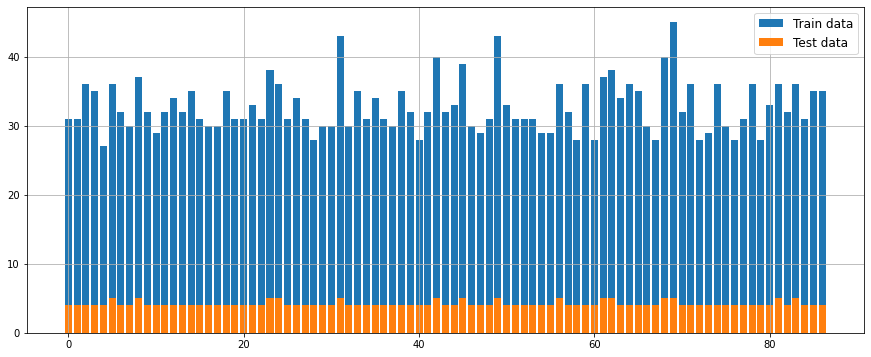

In [6]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk(gemstones_dir):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
    
    # uncomment this block if you want a text output about each subfolder
    #count_dirs = 0
    #for f in dirs:           # count subfolders
        #count_dirs += 1
    #depth = root.split(os.sep)
    #print((len(depth) - 2) * '--'+'>', '{}:\t {} folders, {} imgs'.format(os.path.basename(root), count_dirs, gems[-1] if gems!=[] else 0)) 
    
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

In [7]:
img_w, img_h = 220, 220
train_dir = gemstones_dir + "/train/"
test_dir = gemstones_dir + "/test/"

In [8]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [9]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [10]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


In [11]:
Train_Lbls = pd.get_dummies(Train_Lbls).values

In [12]:
Train_Lbls[25]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

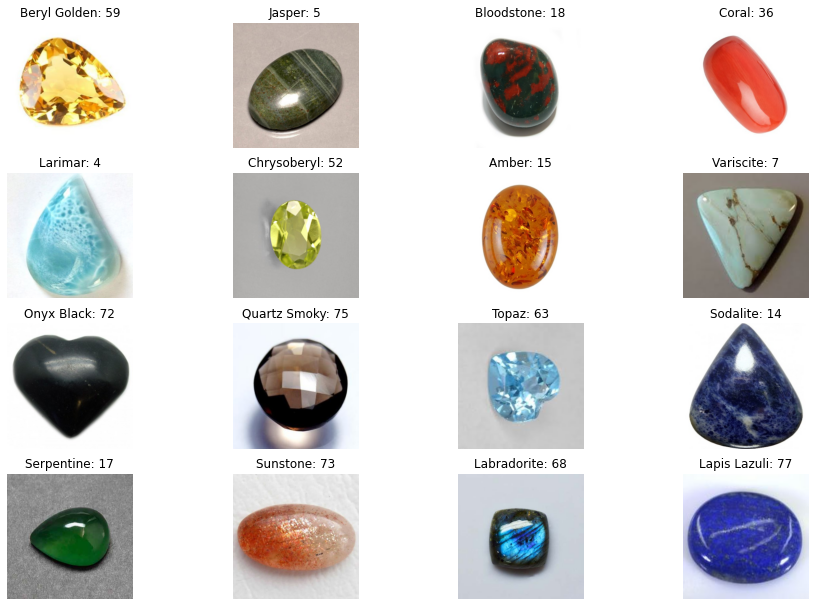

In [13]:
dim = 4 #you can change it;  4x4 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[np.argmax(cl)]+': ' + str(np.argmax(cl)))
        ax[i,j].axis('off')

In [14]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [15]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)   

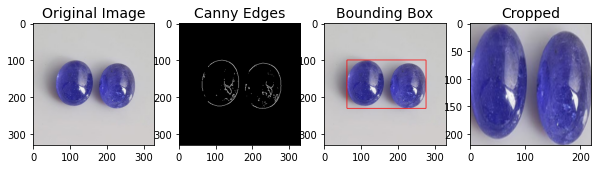

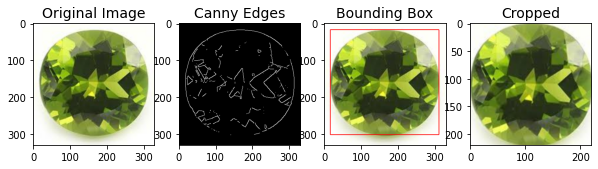

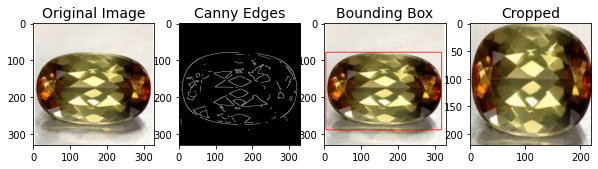

In [16]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [17]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [18]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284, 87) 
Shape of X_val: (572, 220, 220, 3), y_val: (572, 87) 


In [20]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 473388767729306967
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6186094046521346828
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Construindo o modelo

### Carregando o modelo pré-treinado (InceptionV3)

In [21]:
img_shape = (220,220,3)
base_model = tf.keras.applications.InceptionV3(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

In [22]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Congelando o modelo base

In [23]:
base_model.trainable = False
base_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

### Definindo o cabeçalho personalizado da rede neural

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(87, activation = "softmax")(global_average_layer)
prediction_layer

<KerasTensor: shape=(None, 87) dtype=float32 (created by layer 'dense')>

### Definindo o modelo

In [25]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Criando geradores de dados (Data Generators)

Redimensionando as imagens

    Grandes arquiteturas treinadas suportam somente alguns tamanhos pré-definidos.

Por exemplo: MobileNet suporta: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224). No caso da InceptionV3, suporta (220, 220)

In [27]:
data_gen_train = ImageDataGenerator(
      rotation_range=30,       # valor de alcance para randomicamente rotacionar a imagem (exemplo: se for 30 vai rotacionar no maximo 30 graus)
      shear_range=0.1,         # aleatoriamente distorce a imagem (por cisalhamento)
      zoom_range=0.3,          # aleatoriamente aplica zoom na imagem 
      width_shift_range=0.1,   # aleatoriamente alterna as imagens horizontalmente (o valor do parâmetro corresponde à fração da largura total)
      height_shift_range=0.1,  # aleatoriamente alterna as imagens verticalmente (o valor do parâmetro corresponde à fração da largura total)
      horizontal_flip=True,    # aleatoriamente vira as imagens na horizontal
      vertical_flip=False,     # aleatoriamente vira as imagens na vertical 
      rescale=1./255,
      fill_mode='nearest')     # define como vai preencher espaços fora do limite da imagem ('nearest' é o valor padrão)

data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [28]:
batch_size=64
train_generator = data_gen_train.flow(X_train, y_train, batch_size=batch_size)
valid_generator = data_gen_valid.flow(X_val, y_val, batch_size=batch_size)

### Treinando o modelo

## Fine tuning

---




Duas questões principais:

- NÃO USAR Fine Tuning em toda a rede neural, pois somente em algumas camadas já é suficiente. A ideia é adotar parte específica da rede neural para nosso problema específico
- Iniciar o Fine Tuning DEPOIS que finalizou a transferência de aprendizagem. Se você tentar o Fine Tuning imediatamente, os gradientes serão muito diferentes entre o cabeçalho personalizado e algumas camadas descongeladas do modelo base 

### Descongelando algumas camadas do topo do modelo base

In [29]:
base_model.trainable = True
len(base_model.layers)

311

In [30]:
fine_tuning_at = 200

In [31]:
for layer in base_model.layers[fine_tuning_at:]:
  layer.trainable = False

# for layer in base_model.layers[:fine_tuning_at]:
#   layer.trainable = False

### Compilando o modelo COM fine tuning

In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [33]:
model.compile(loss = categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              metrics = ['accuracy',f1_m,precision_m, recall_m])

arquivo_modelo = base_url + '.h5'
arquivo_modelo_json = base_url + '.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

### Fine tuning

In [34]:
epochs = 70
history = model.fit(
          train_generator,
          epochs=epochs,
          verbose=1,
          validation_data= valid_generator,
          callbacks=[lr_reducer, early_stopper, checkpointer]
)

Epoch 1/70
36/36 [==============================] - 92s 1s/step - loss: 4.4495 - accuracy: 0.0363 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.3248 - val_accuracy: 0.0455 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.32481, saving model to /content/gdrive/My Drive/reconhecimento-padroes/model_gemstones_transferlearning_finetuning_oficial.h5
Epoch 2/70
36/36 [==============================] - 41s 1s/step - loss: 3.8386 - accuracy: 0.1449 - f1_m: 0.0118 - precision_m: 0.3056 - recall_m: 0.0060 - val_loss: 3.9210 - val_accuracy: 0.1084 - val_f1_m: 0.0068 - val_precision_m: 0.2222 - val_recall_m: 0.0035

Epoch 00002: val_loss improved from 4.32481 to 3.92098, saving model to /content/gdrive/My Drive/reconhecimento-padroes/model_gemstones_transferlearning_finetuning_oficial.h5
Epoch 3/70
36/36 [==============================] - 41s 1s/step - loss: 3.1172 - accuracy: 0.2982 - 

In [35]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

### Avaliação do modelo com fine tuning

In [36]:
score = model.evaluate_generator(valid_generator)

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:1.0322669744491577
accuracy:0.7342657446861267
f1_m:0.7415879964828491
precision_m:0.7766017913818359
recall_m:0.710185170173645


In [37]:
score = model.evaluate_generator(valid_generator, steps= len(valid_generator))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:1.0322668552398682
accuracy:0.7342657446861267
f1_m:0.7409795522689819
precision_m:0.7757591009140015
recall_m:0.7097222208976746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


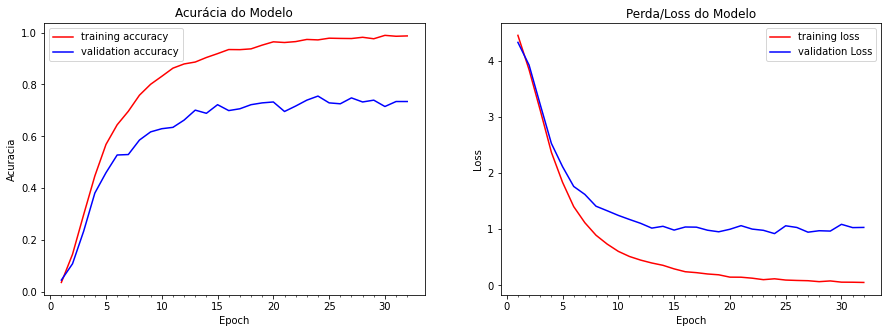

In [38]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('/content/gdrive/My Drive/reconhecimento-padroes/model_history.pdf', bbox_inches='tight')
    plt.show()

plota_historico_modelo(history)

In [39]:
score = model.evaluate_generator(valid_generator, steps= len(valid_generator))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:1.0322667360305786
accuracy:0.7342657446861267
f1_m:0.7397387623786926
precision_m:0.7743301391601562
recall_m:0.7086805701255798


In [40]:
type(Train_Imgs)
Train_Imgs = np.linspace(0,100, 10000000)
Train_Imgs = None
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

train_generator.reset()
valid_generator.reset()
train_generator = None
valid_generator = None

gc.collect()

8952

In [41]:
Test_Imgs, Test_Lbls = read_imgs_lbls(test_dir)
Test_Lbls = get_class_index(Test_Lbls)
print('Shape of test images: {}'.format(Test_Imgs.shape))
print('Shape of test labels: {}'.format(Test_Lbls.shape))
Test_Lbls = pd.get_dummies(Test_Lbls).values

Test_Imgs = crop_images(Test_Imgs)
print('Final shape of images in test set: {} '.format(Test_Imgs.shape))

Shape of test images: (363, 330, 330, 3)
Shape of test labels: (363,)
Final shape of images in test set: (363, 220, 220, 3) 


In [42]:
def normalize(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [43]:
Test_Imgs = normalize(Test_Imgs)

In [44]:
data_test_valid = ImageDataGenerator()
test_generator = data_test_valid.flow(Test_Imgs, Test_Lbls, batch_size=batch_size)
score = model.evaluate_generator(test_generator, steps= len(test_generator))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

np.save(base_url + '_mod_xtest', Test_Imgs)
np.save(base_url + '_mod_ytest', Test_Lbls)
# ESTAS IMAGENS ESTÃO NORMALIZADAS

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:1.0838099718093872
accuracy:0.7190082669258118
f1_m:0.7303827404975891
precision_m:0.7678424715995789
recall_m:0.6969476342201233


In [45]:
true_y=[]
pred_y=[]
x = np.load(base_url + '_mod_xtest.npy')
y = np.load(base_url + '_mod_ytest.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0

In [46]:
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 73.00275482093664%


[[3 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]


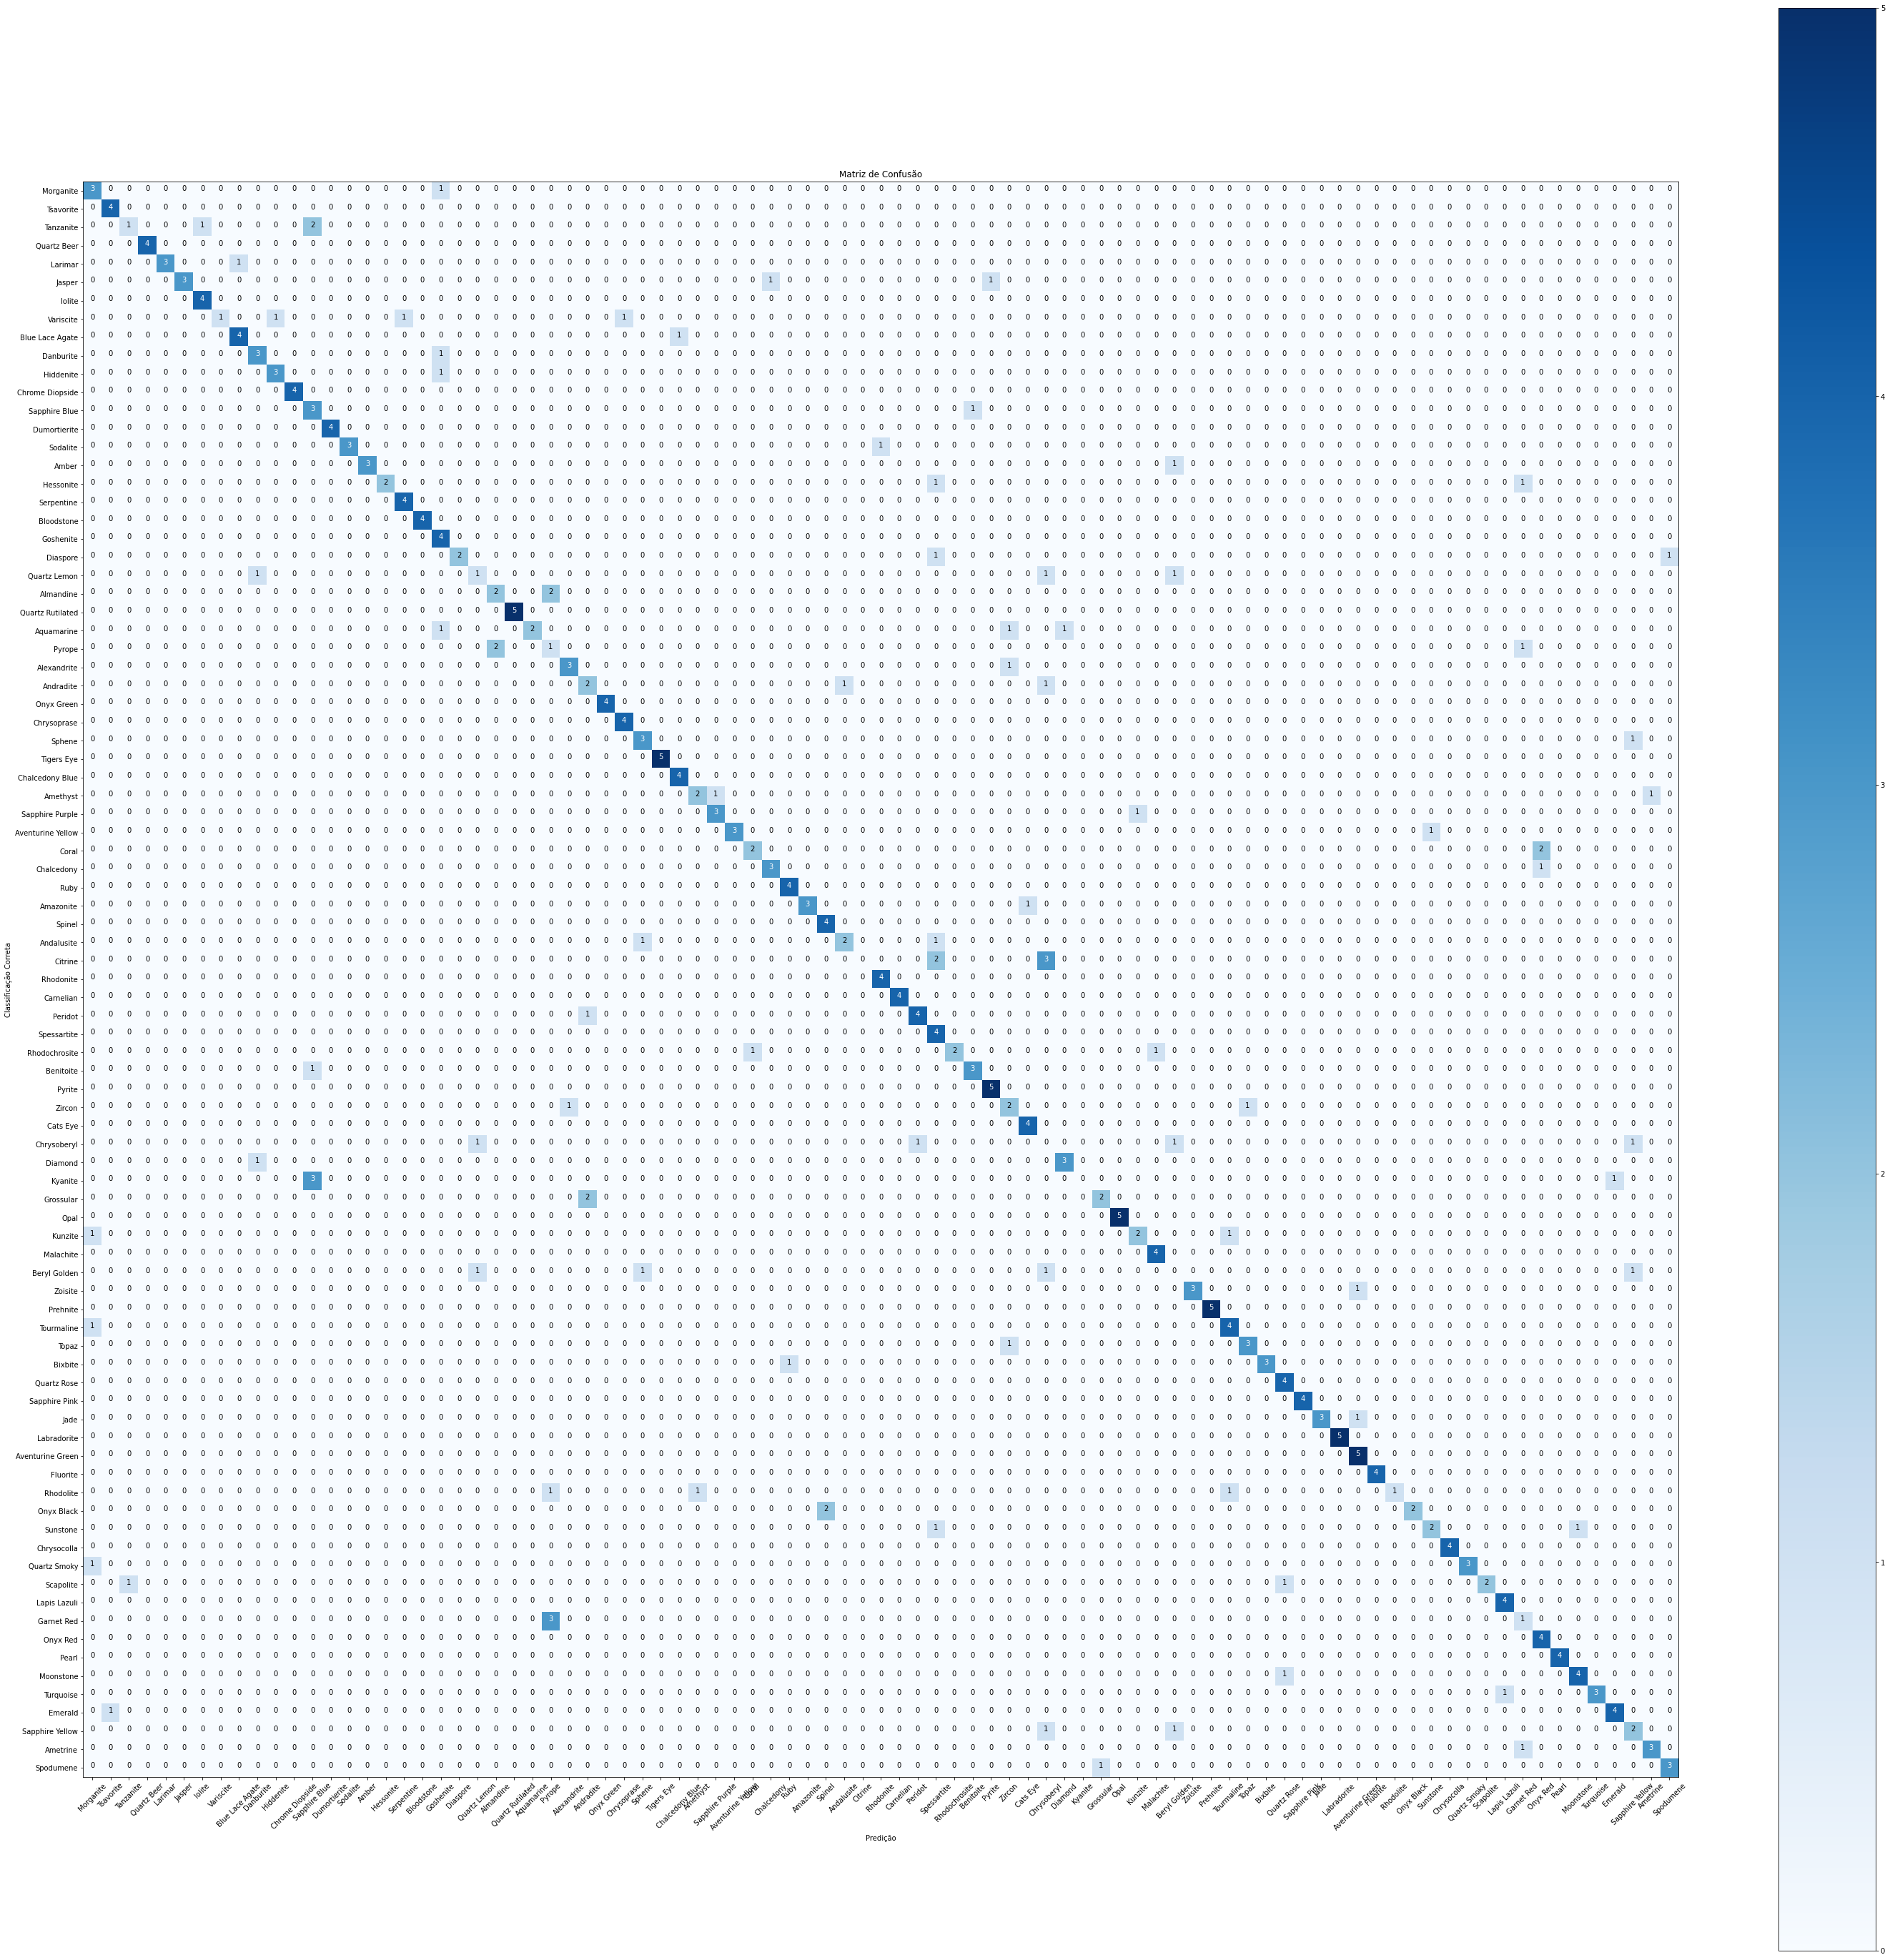

In [47]:
import itertools
from sklearn.metrics import confusion_matrix

y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')

cm = confusion_matrix(y_true, y_pred)
titulo='Matriz de Confusão'
print(cm)
plt.figure(figsize = (50,50))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('/content/gdrive/My Drive/reconhecimento-padroes/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

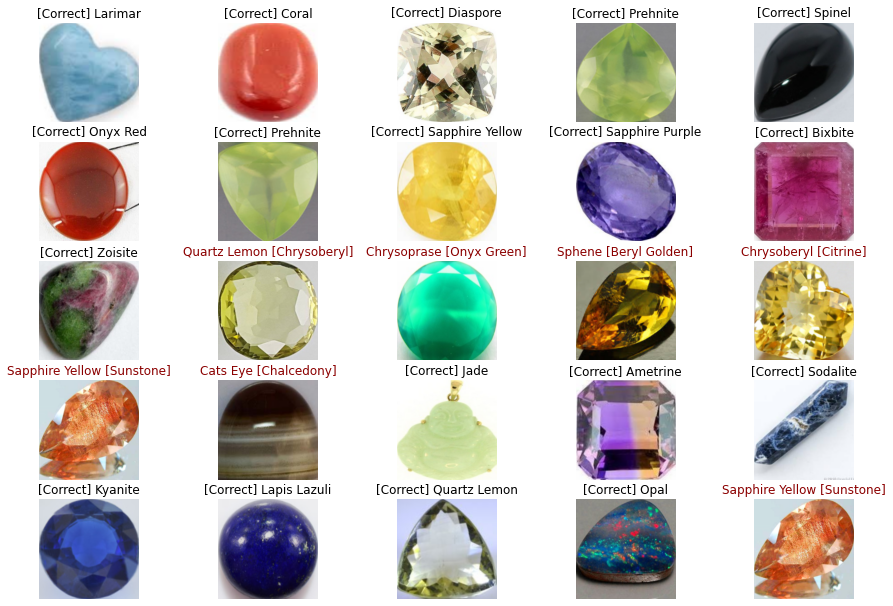

In [48]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = model.predict(pred_image)
        pred_class=np.argmax(pred_class,axis=1)[0]
        pred_prob = model.predict(pred_image).reshape(87)
        # print("predclass " + str(pred_class) + " - " + "rnd " + str(rnd_number))
        # print(Test_Lbls)
        act = CLASSES[np.argmax(Test_Lbls[rnd_number])]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(CLASSES[pred_class] != CLASSES[np.argmax(Test_Lbls[rnd_number])]):
            t = '{} [{}]'.format(CLASSES[pred_class], CLASSES[np.argmax(Test_Lbls[rnd_number])])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[Correct] {}'.format(CLASSES[pred_class]) 
            ax[i,j].set_title(t)
        ax[i,j].axis('off')
f.savefig('/content/gdrive/My Drive/reconhecimento-padroes/last_test.pdf', bbox_inches='tight')